<a href="https://colab.research.google.com/github/thanhtruchhh/GA_Data_Analysis_With_SQL_BigQuery/blob/main/EDA_of_GA_Data_with_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this project is analysis the [Google Merchandise Store](https://www.googlemerchandisestore.com/shop.axd/Home?utm_source=Partners&utm_medium=affiliate&utm_campaign=Data%20Share%20Promo) dataset from BigQuery using SQL.

For this analysis we'll focus on 3 main goals:
* Understand the composition of current site traffic.
* Understand the flow and conversion path of users.
* Understand user behavior on the site.

The period for this analysis will be in 2017.

# Connect to BigQuery

In [1]:
# Verify account
from google.colab import auth
auth.authenticate_user()
print('Authentication success!')

Authentication success!


In [26]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from plotly import graph_objects as go

In [3]:
# Create a Client object
client = bigquery.Client(project = 'dac-k16-sql-project-1')

# Construct a ref to the ga dataset
dataset_ref = client.dataset('google_analytics_sample', project = 'bigquery-public-data')

# API request - Fetch the dataset
dataset = client.get_dataset(dataset_ref)

In [4]:
# View some 1st tables in dataset
tables = list(client.list_tables(dataset_ref))
for i in range(5):
  print(tables[i].table_id)

ga_sessions_20160801
ga_sessions_20160802
ga_sessions_20160803
ga_sessions_20160804
ga_sessions_20160805


# Explore the table structure

In [5]:
# Construct a ref to the table
table_ref_20160801 = dataset_ref.table('ga_sessions_20160801')

# API request - fetch the table
table_20160801 = client.get_table(table_ref_20160801)

# View 1st lines of the table
client.list_rows(table_20160801, max_results = 5).to_dataframe()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,<NA>,1,1470046245,1470046245,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",895954260133011192,None,Organic Search,Not Socially Engaged
1,<NA>,1,1470084717,1470084717,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 18, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",0288478011259077136,None,Direct,Not Socially Engaged
2,<NA>,3,1470078988,1470078988,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",6440789996634275026,None,Organic Search,Not Socially Engaged
3,<NA>,4,1470075581,1470075581,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 19, 'ti...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 11, 'minu...",8520115029387302083,None,Referral,Not Socially Engaged
4,<NA>,30,1470099026,1470099026,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 17, 'minu...",6792260745822342947,None,Organic Search,Not Socially Engaged


In [6]:
# Retrieve the schema of a table
for field in table_20160801.schema:
  field_name = field.name
  field_type = field.field_type
  print('{}: {}'.format(field_name, field_type))
  if(field_type == 'RECORD'):
    for sub_field in field.fields:
      sub_field_name = sub_field.name
      sub_field_type = sub_field.field_type
      print('{}.{}: {}'.format(field_name, sub_field_name, sub_field_type))


visitorId: INTEGER
visitNumber: INTEGER
visitId: INTEGER
visitStartTime: INTEGER
date: STRING
totals: RECORD
totals.visits: INTEGER
totals.hits: INTEGER
totals.pageviews: INTEGER
totals.timeOnSite: INTEGER
totals.bounces: INTEGER
totals.transactions: INTEGER
totals.transactionRevenue: INTEGER
totals.newVisits: INTEGER
totals.screenviews: INTEGER
totals.uniqueScreenviews: INTEGER
totals.timeOnScreen: INTEGER
totals.totalTransactionRevenue: INTEGER
totals.sessionQualityDim: INTEGER
trafficSource: RECORD
trafficSource.referralPath: STRING
trafficSource.campaign: STRING
trafficSource.source: STRING
trafficSource.medium: STRING
trafficSource.keyword: STRING
trafficSource.adContent: STRING
trafficSource.adwordsClickInfo: RECORD
trafficSource.isTrueDirect: BOOLEAN
trafficSource.campaignCode: STRING
device: RECORD
device.browser: STRING
device.browserVersion: STRING
device.browserSize: STRING
device.operatingSystem: STRING
device.operatingSystemVersion: STRING
device.isMobile: BOOLEAN
device.m

We can see that the `totals`, `trafficSource`, `device`, `geoNetwork`, `customDimensions`, and `hits` columns contain nested data.

For more detailed information on the dataset schema, you can refer to [the Google Analytics documentation](https://support.google.com/analytics/answer/3437719?hl=en).

# Explore and analyze data

We will analyze by answer questions [here](https://github.com/thanhtruchhh/GA_Data_Analysis_With_SQL_BigQuery#questions), visualize some charts, interpret results and make some suggestions.

## Total visits, pageviews, and transactions for Jan, Feb, and March 2017

In [9]:
query = '''
  SELECT
    FORMAT_DATE('%Y-%m', (PARSE_DATE('%Y%m%d', date))) AS month,
    COUNT(fullVisitorId) AS visits,
    SUM(totals.pageviews) AS pageviews,
    SUM(totals.transactions) AS transactions
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_2017*`
  WHERE _TABLE_SUFFIX BETWEEN '0101' AND '0331'
  GROUP BY 1
  ORDER BY 1;
'''

query_job = client.query(query)
result = query_job.to_dataframe()
result['conversion_rate'] = result['transactions'] / result['visits'] * 100
result

,month,visits,pageviews,transactions,conversion_rate
0,2017-01,64694,257708,713,1.102111
1,2017-02,62192,233373,733,1.178608
2,2017-03,69931,259522,993,1.419971


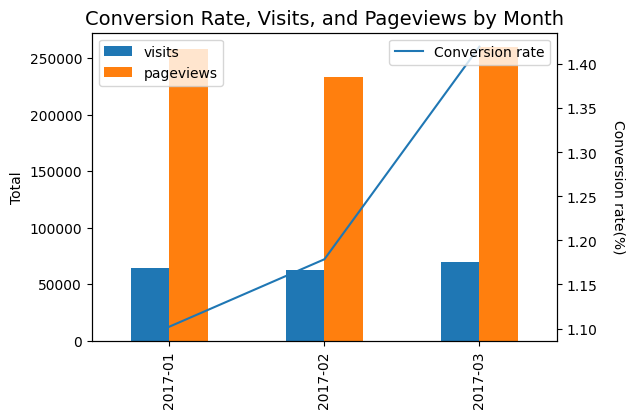

In [10]:
# Create the bar chart for visits and pageviews
ax1 = result[['visits', 'pageviews']].plot(kind = 'bar', figsize = (6, 4))
ax1.set_ylabel('Total')

# Create the line chart for conversion_rate on a 2nd y-axis
ax2 = ax1.twinx()
ax2.plot(result['conversion_rate'], label = 'Conversion rate')
ax2.set_ylabel('Conversion rate(%)', rotation = -90, labelpad=20)

# Add legends
ax1.legend(loc='upper left', fontsize = 10)
ax2.legend(loc='upper right', fontsize = 10)

# Custome X-axis labels
ax1.set_xticks(range(len(result)))
ax1.set_xticklabels(result['month'])

plt.title('Conversion Rate, Visits, and Pageviews by Month', fontsize = 14)
plt.show()

* The number of visits to the website remained relatively stable in Jan and Feb, there was a noticeable increase in Mar.
* Pageview also increased in Mar, corresponding with the rise in total visits.
* The conversion rate has been increasing over the 1st quarter of 2017, from 1.10% in Jan to 1.42% in Mar. There might be the factors *(changes in customer behavior or the company's marketing strategies)* that lead to an increase in conversion rate.

##  Bounce rate per traffic source in July 2017

In [29]:
query = '''
  SELECT
    trafficSource.source,
    COUNT(fullVisitorId) AS total_visits,
    COUNT(totals.bounces) AS total_bounces,
    100 * COUNT(totals.bounces) / COUNT(fullVisitorId) AS bounce_rate
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201707*`
  GROUP BY 1
  ORDER BY 2 DESC;
'''

query_job = client.query(query)
result = query_job.to_dataframe()
result.head(10)

,source,total_visits,total_bounces,bounce_rate
0,google,38400,19798,51.557292
1,(direct),19891,8606,43.265799
2,youtube.com,6351,4238,66.729649
3,analytics.google.com,1972,1064,53.955375
4,Partners,1788,936,52.348993
5,m.facebook.com,669,430,64.275037
6,google.com,368,183,49.728261
7,dfa,302,124,41.059603
8,sites.google.com,230,97,42.173913
9,facebook.com,191,102,53.403141


In [28]:
search_engines = [
    'google',
    'yahoo',
    'bing',
    'duckduckgo',
    'ask\\.com',
    'baidu',
    'search'
]

search_engine_pattern = r".*|".join(search_engines)

# Use the `str.contains()` method with the regular expression pattern
search_engine_df = result[result['source'].str.contains(search_engine_pattern, flags=re.IGNORECASE, regex = True)]

# Display the filtered DataFrame
search_engine_df.sort_values(by = 'bounce_rate', ascending = False)

,source,total_visits,total_bounces,bounce_rate
77,mx.search.yahoo.com,1,1,100.000000
94,google.es,1,1,100.000000
76,images.google.com.au,1,1,100.000000
84,google.bg,1,1,100.000000
89,malaysia.search.yahoo.com,1,1,100.000000
61,search.1and1.com,2,2,100.000000
57,au.search.yahoo.com,2,2,100.000000
44,search.xfinity.com,6,6,100.000000
81,es.search.yahoo.com,1,1,100.000000
37,search.mysearch.com,12,11,91.666667


In [14]:
result.head(20).sort_values(by = 'bounce_rate').head(5)

,source,total_visits,total_bounces,bounce_rate
15,mail.google.com,101,25,24.752475
10,reddit.com,189,54,28.571429
17,blog.golang.org,65,19,29.230769
16,yahoo,100,41,41.000000
7,dfa,302,124,41.059603


* The bounce rates for the different sources vary widely.
* Search engines *(google, yahoo, baidu, duckduckgo...)* have high bounce rate. It indicates users arriving from there are not finding what they are looking for or are not engaged effectively &rarr; Need optimize the landing pages to ensure they match search intent, and work on providing compelling and relevant content to keep visitors engaged.
* Google, (direct), and youtube.com are the top sources of visits, but a significant portion of visitors from these sources are leaving the site without engaging further *(>40%)*:
  * Direct: There might be UI/UX issues on the website &rarr; Collect user feedback to identify and address these issues.
  * YouTube: Visitors arriving from YouTube might not be finding what they expect or are not encouraged to explore the site further &rarr; Opitimize the landing pages or creating more compelling CTA on the site.
* reddit.com, mail.google.com, and blog.golang.org have relatively high total visits and low bounce rates *(<30%)*, which indicates that these sources are performing well in terms of visitor engagement and retention:
  *  Reddit: Paricipate actively in relevant subreddits, response to comments, and contribute positively to discussions related to the company's content.
  *  Mail:
    * Segment the email list.
    * Personalize emails: Use the receipient's name, send personalized recommendations based on their past interactions with the website.
    * Ensure that the content in emails is both relevant and valuable to the receipients: product recommendations, special offers, educational content...
  * Go blog: Continue diversifying the content on this blog, respond to comments on blog posts.

## Revenue by traffic source by week, by month in June 2017

In [30]:
query = '''
  WITH revenue_by_month AS (
    SELECT
      'Month' AS time_type,
      FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', date)) AS time,
      trafficSource.source AS source,
      SUM(productRevenue) / 1000000 AS revenue
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201706*`,
    UNNEST (hits) hits,
    UNNEST (hits.product) product
    GROUP BY 2, 3
  ),

  revenue_by_week AS (
    SELECT
      'Week' AS time_type,
      FORMAT_DATE('%Y%W', PARSE_DATE('%Y%m%d', date)) AS time,
      trafficSource.source AS source,
      SUM(productRevenue) / 1000000 AS revenue
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201706*`,
    UNNEST (hits) hits,
    UNNEST (hits.product) product
    GROUP BY 2, 3
  )

  SELECT *
  FROM revenue_by_week
  UNION ALL
  SELECT *
  FROM revenue_by_month
  ORDER BY 4 DESC;
'''

query_job = client.query(query)
result = query_job.to_dataframe()
result.head(20)

,time_type,time,source,revenue
0,Month,2017-06,(direct),97333.619695
1,Week,201724,(direct),30908.909927
2,Week,201725,(direct),27295.319924
3,Month,2017-06,google,18757.179920
4,Week,201723,(direct),17325.679919
5,Week,201726,(direct),14914.809950
6,Week,201724,google,9217.169976
7,Month,2017-06,dfa,8862.229996
8,Week,201722,(direct),6888.899975
9,Week,201726,google,5330.569964


Revenue from the direct, google, dfa traffic sources are among the highest:
* Direct traffic often includes loyal customers, who directly type the URL into their browser or use bookmarks to access the site &rarr; Have high conversion rates.
* Given the widespread use of Google for searching, it's common to see significant traffic and revenue from this source.
* Advertising campaigns managed through DoubleClick for Advertisers *(dfa)* are generating income for the company &rarr;Advertising efforts are driving sales or conversions.


## Average number of pageviews by purchaser type in June, July 2017

 *Purchaser type (purchasers vs non-purchasers)*

In [32]:
query = '''
    SELECT
      FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', date)) AS month,
      CASE
        WHEN totals.transactions >=1 AND productRevenue IS NOT NULL THEN 'purchaser'
        ELSE 'non-purchaser'
      END AS purchaser_type,
      SUM(totals.pageviews) / COUNT(DISTINCT fullVisitorId) AS avg_pageviews_purchase
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_2017*`,
    UNNEST (hits) hits,
    UNNEST (hits.product) product
    WHERE _TABLE_SUFFIX BETWEEN '0601' AND '0731'
    GROUP BY 1, 2
    ORDER BY 1;
'''

query_job = client.query(query)
result = query_job.to_dataframe()
result

,month,purchaser_type,avg_pageviews_purchase
0,2017-06,non-purchaser,384.391424
1,2017-06,purchaser,94.020501
2,2017-07,non-purchaser,412.858560
3,2017-07,purchaser,124.237552


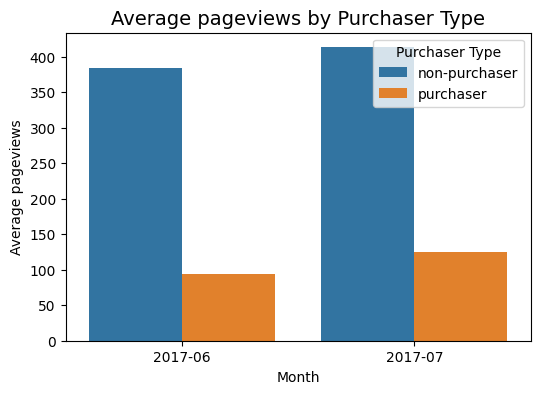

In [33]:
plt.figure(figsize = (6, 4))
sns.barplot(data = result, x = 'month', y = 'avg_pageviews_purchase', hue = 'purchaser_type')

plt.xlabel('Month')
plt.ylabel('Average pageviews')
plt.title('Average pageviews by Purchaser Type', fontsize = 14)
plt.legend(title='Purchaser Type')

plt.show()

-  The average number of pageviews increased in July for both 2 groups.
-  Non-purchasers are more actively exploring the website's content, browsing various pages, or spending more time on the site. It indicates that these users are engaged with the company conte but might face barriers *(pricing, unclear navigation, a lack of trust, or difficulties in the purchase process..)* &rarr; Optimize the user journey, provide more attractive and clearer CTAs, offer vouchers, flash sales.
-  Purchasers may have a more specific goal in mind, leading to fewer pageviews on average &rarr; Ensure a smoth payment experience + Recommend products beforing checking out.

## Average number of transactions per user that made a purchase in July 2017

*Notes*:
- *Purchaser: `totals.transactions` >= 1; `productRevenue` is not null. `fullVisitorId` field is user id.*
- *Add condition "product.productRevenue is not null" to calculate correctly.*

In [34]:
query = '''
  SELECT
    FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d' ,date)) AS Month,
    SUM(totals.transactions) / COUNT(DISTINCT fullVisitorId) AS Avg_total_transactions_per_user
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201707*`,
  UNNEST(hits) hits,
  UNNEST(hits.product) product
  WHERE
    productRevenue IS NOT NULL
    AND totals.transactions >= 1
  GROUP BY 1;
'''

query_job = client.query(query)
result = query_job.to_dataframe()
result

,Month,Avg_total_transactions_per_user
0,201707,4.1639


Average number of transactions per user that made a purchase in July 2017 is 4.

## Average amount of money spent per session. Only include purchaser data in July 2017

In [35]:
query = '''
  SELECT
    FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS Month,
    (SUM(productRevenue) / 1000000 )/ COUNT(totals.visits) AS avg_revenue_by_user_per_visit
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201707*`,
  UNNEST (hits) hits,
  UNNEST (hits.product) product
  WHERE totals.transactions >= 1
    AND productRevenue IS NOT NULL
  GROUP BY 1;
'''

query_job = client.query(query)
result = query_job.to_dataframe()
result

,Month,avg_revenue_by_user_per_visit
0,201707,43.856598


Average amount of money spent per session in July 2017 is $43.86.

## Other products purchased by customers who purchased product "YouTube Men's Vintage Henley" in July 2017

**Steps:**
1. Identify all customers who bought 'YouTube Men's Vintage Henley' in July 2017.
2. Find purchased products of these customer, exclude the 'YouTube Men's Vintage Henley'.
*Note: Add condition `product.productRevenue` is not null to calculate correctly.*

In [36]:
query = '''
  WITH customers_bought_henley AS (
    SELECT fullVisitorId
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201707*`,
    UNNEST (hits) hits,
    UNNEST (hits.product) product
    WHERE v2ProductName = "YouTube Men's Vintage Henley"
      AND totals.transactions IS NOT NULL
      AND productRevenue IS NOT NULL
  )

  SELECT
    v2ProductName AS other_purchased_products,
    SUM(productQuantity) AS quantity
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST (hits) hits,
  UNNEST (hits.product) product
  WHERE fullVisitorId IN (SELECT * FROM customers_bought_henley)
    AND totals.transactions IS NOT NULL
    AND productRevenue IS NOT NULL
    AND v2ProductName != "YouTube Men's Vintage Henley"
  GROUP BY 1
  ORDER BY 2 DESC;
'''

query_job = client.query(query)
result = query_job.to_dataframe()
result

,other_purchased_products,quantity
0,Google Sunglasses,20
1,Google Women's Vintage Hero Tee Black,7
2,SPF-15 Slim & Slender Lip Balm,6
3,Google Women's Short Sleeve Hero Tee Red Heather,4
4,YouTube Men's Fleece Hoodie Black,3
5,Google Men's Short Sleeve Badge Tee Charcoal,3
6,Recycled Mouse Pad,2
7,Red Shine 15 oz Mug,2
8,YouTube Twill Cap,2
9,Android Wool Heather Cap Heather/Black,2


- Google Sunglasses stands out with a substantial quantity of 20.
- The list includes different types, including short sleeve, hoodies, or lip balm, for men or women &rarr; Customers who bought the Henley shirt had a diverse range of preferences, both in terms of style and gender-specific items.
- These products appear to be related to Google or YouTube indicating a level of brand loyalty or interest in related items.

&rarr; Cross-sell or make recommendations for customers who bought the Henley shirt.

##  Conversion path from product view to addtocart to purchase in Jan, Feb and March 2017


In [37]:
query = '''
  SELECT
    FORMAT_DATE('%Y-%m', PARSE_DATETIME('%Y%m%d', date)) AS month,
    COUNT(
      CASE WHEN eCommerceAction.action_type = '2' THEN 1 END
    ) AS num_product_view,
    COUNT(
      CASE WHEN eCommerceAction.action_type = '3' THEN 1 END
    ) AS num_addtocart,
    COUNT(
      CASE WHEN eCommerceAction.action_type = '6' AND product.productRevenue IS NOT NULL THEN 1 END
    ) AS num_purchase
  FROM `bigquery-public-data.google_analytics_sample.ga_sessions_2017*`,
  UNNEST (hits) hits,
  UNNEST (hits.product) product
  WHERE _TABLE_SUFFIX BETWEEN '0101' AND '0331'
  GROUP BY month
  ORDER BY 1;
'''

query_job = client.query(query)
result = query_job.to_dataframe()
result

,month,num_product_view,num_addtocart,num_purchase
0,2017-01,25787,7342,2143
1,2017-02,21489,7360,2060
2,2017-03,23549,8782,2977


In [38]:
fig = go.Figure()

for i in range(result.shape[0]):
  fig.add_trace(
      go.Funnel(
        name = result.iloc[i][0],
        y = ['View', 'Add to cart', 'Purchase'],
        x = result.iloc[i][1:4],
        textinfo = "value+percent initial"
      )
  )

fig.update_layout(title_text = 'Google Merchandise Store Conversion Path')

fig.show()

- The cohort map tracks the progression of users through the conversion funnel: Product view &rarr; add to cart &rarr; purchase.
- Over 3 months, there are consistent increase in convertion rate (`add_to_cart_rate` and `purchase_rate`). It could be influenced by various factors, including seasonal trends or marketing campaigns. It's worth investigating whether specific events or promotions had an impact on user behavior.